In [48]:
import os
import h5py
import json
import random
import pickle
import scipy
import time
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm
from PIL import Image
from celluloid import Camera # getting the camera
from IPython.display import HTML # to show the animation in Jupyter

import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(font_scale = 4)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['lines.linewidth'] = 5
matplotlib.rcParams['axes.linewidth'] = 5
matplotlib.rcParams['lines.markersize'] = 14
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.xmargin'] = 0.1
matplotlib.rcParams['axes.ymargin'] = 0.1
# matplotlib.rc('font', **{'weight': 'normal', 'size': 8})

total_BASE = "/Users/jessicaechterhoff/Dropbox/UCSD_2022_2023/Research/toyota/toyota_2.0/Data Set/once/train/data/"
all_sequence_bases = os.listdir(total_BASE)
all_sequence_bases = list(map(lambda s: "{}/{}/{}.json".format(total_BASE, s, s), all_sequence_bases))

In [49]:
all_sequence_bases = []
for elem in os.listdir(total_BASE):
    if "DS" in elem: continue
    for file in os.listdir(total_BASE + elem):
        if "json" in file:
            all_sequence_bases.append(total_BASE + elem + "/" + file)

all_sequence_bases

['/Users/jessicaechterhoff/Dropbox/UCSD_2022_2023/Research/toyota/toyota_2.0/Data Set/once/train/data/000113/000113.json',
 '/Users/jessicaechterhoff/Dropbox/UCSD_2022_2023/Research/toyota/toyota_2.0/Data Set/once/train/data/000092/000092.json',
 '/Users/jessicaechterhoff/Dropbox/UCSD_2022_2023/Research/toyota/toyota_2.0/Data Set/once/train/data/000080/000080.json',
 '/Users/jessicaechterhoff/Dropbox/UCSD_2022_2023/Research/toyota/toyota_2.0/Data Set/once/train/data/000121/000121.json',
 '/Users/jessicaechterhoff/Dropbox/UCSD_2022_2023/Research/toyota/toyota_2.0/Data Set/once/train/data/000076/000076.json',
 '/Users/jessicaechterhoff/Dropbox/UCSD_2022_2023/Research/toyota/toyota_2.0/Data Set/once/train/data/000104/000104.json']

In [50]:
def load_pkl(load_path):
    with open(load_path, 'rb') as f:
        pkl_data = pickle.load(f, encoding='latin1')
    return pkl_data

def load_json(path_to_file):
    with open(path_to_file) as p:
        return json.load(p)

In [51]:
print("# sequences: ", len(all_sequence_bases))
a = load_json(all_sequence_bases[3])
print(a.keys())
print(a['meta_info'])
print(len(a['frames']))
print(a['frames'][0].keys())
print(a['frames'][1]['frame_id'])
print(a['frames'][0]['pose'])
print(a['frames'][0]['annos'].keys())
print(len(a['frames'][0]['annos']['names']))
print(len(a['frames'][0]['annos']['boxes_3d']))
print(a['frames'][0]['annos']['boxes_2d'].keys())
print(a['frames'][0]['annos']['boxes_2d']['cam01'][0])

# sequences:  6
dict_keys(['meta_info', 'calib', 'frames'])
{'weather': 'sunny', 'period': 'noon', 'image_size': [1920, 1020], 'point_feature_num': 4}
1714
dict_keys(['sequence_id', 'frame_id', 'annos', 'pose'])
1616617724999
[4.068500405827719e-05, 0.0002765444844888617, 0.0001707027552665324, 0.9999999463642225, 0.012837268015204347, -0.007687712239594699, 0.005897593491877522]
dict_keys(['names', 'boxes_3d', 'boxes_2d'])
47
47
dict_keys(['cam01', 'cam03', 'cam05', 'cam06', 'cam07', 'cam08', 'cam09'])
[0.0, 0.0, 1920.0, 1020.0]


In [52]:
def get_speed(vel):
    return np.sum(np.array(vel) ** 2) ** 0.5

def angle(v1, v2):
    # [0, np.pi]
    return np.arccos(np.dot(v1, v2) / (get_speed(v1) * get_speed(v2)))

def dist(p1, p2):
    return get_speed(np.array(p1) - np.array(p2))

In [53]:
a = load_json(all_sequence_bases[0])

In [54]:
a.keys()

dict_keys(['meta_info', 'calib', 'frames'])

In [44]:
a['calib']['cam01'].keys()

dict_keys(['cam_to_velo', 'cam_intrinsic', 'distortion'])

[0.05090454767703861, -2.0186817274439357, -0.029561757366207083]
[0.13283043410492404, -5.620830051454568, -0.049681844477722815]
[0.27788181921459215, -9.47719699081974, -0.08583931200965562]
[0.5540587988953551, -13.451316076163524, -0.09508292136064471]
[1.0346255907917001, -17.35112848391009, -0.11765609940558829]
[1.7494528194847105, -21.16772207926391, -0.12015108284591437]
[2.6884543700950725, -24.973478495753586, -0.14816439084457206]
[4.059229699513472, -28.936807779813098, -0.11950345075656747]
[5.932798678601507, -32.90102451059915, -0.09634470131417047]
[8.22832882138825, -37.0186074078297, -0.05660203004151323]
[10.842558084975476, -41.324023933412455, 0.01926106780986558]
[0.00389971892772158, -0.2822439952994815, -4.024190274490822e-05]
[-0.051074034384425274, -1.5901093605929675, -0.013255732514819325]
[-0.20769354304863738, -2.8109651203132433, -0.0006251665154621995]
[-0.5516571741426542, -3.9626028625634175, 0.017887358106125868]
[-1.0825837455926532, -5.07547565649

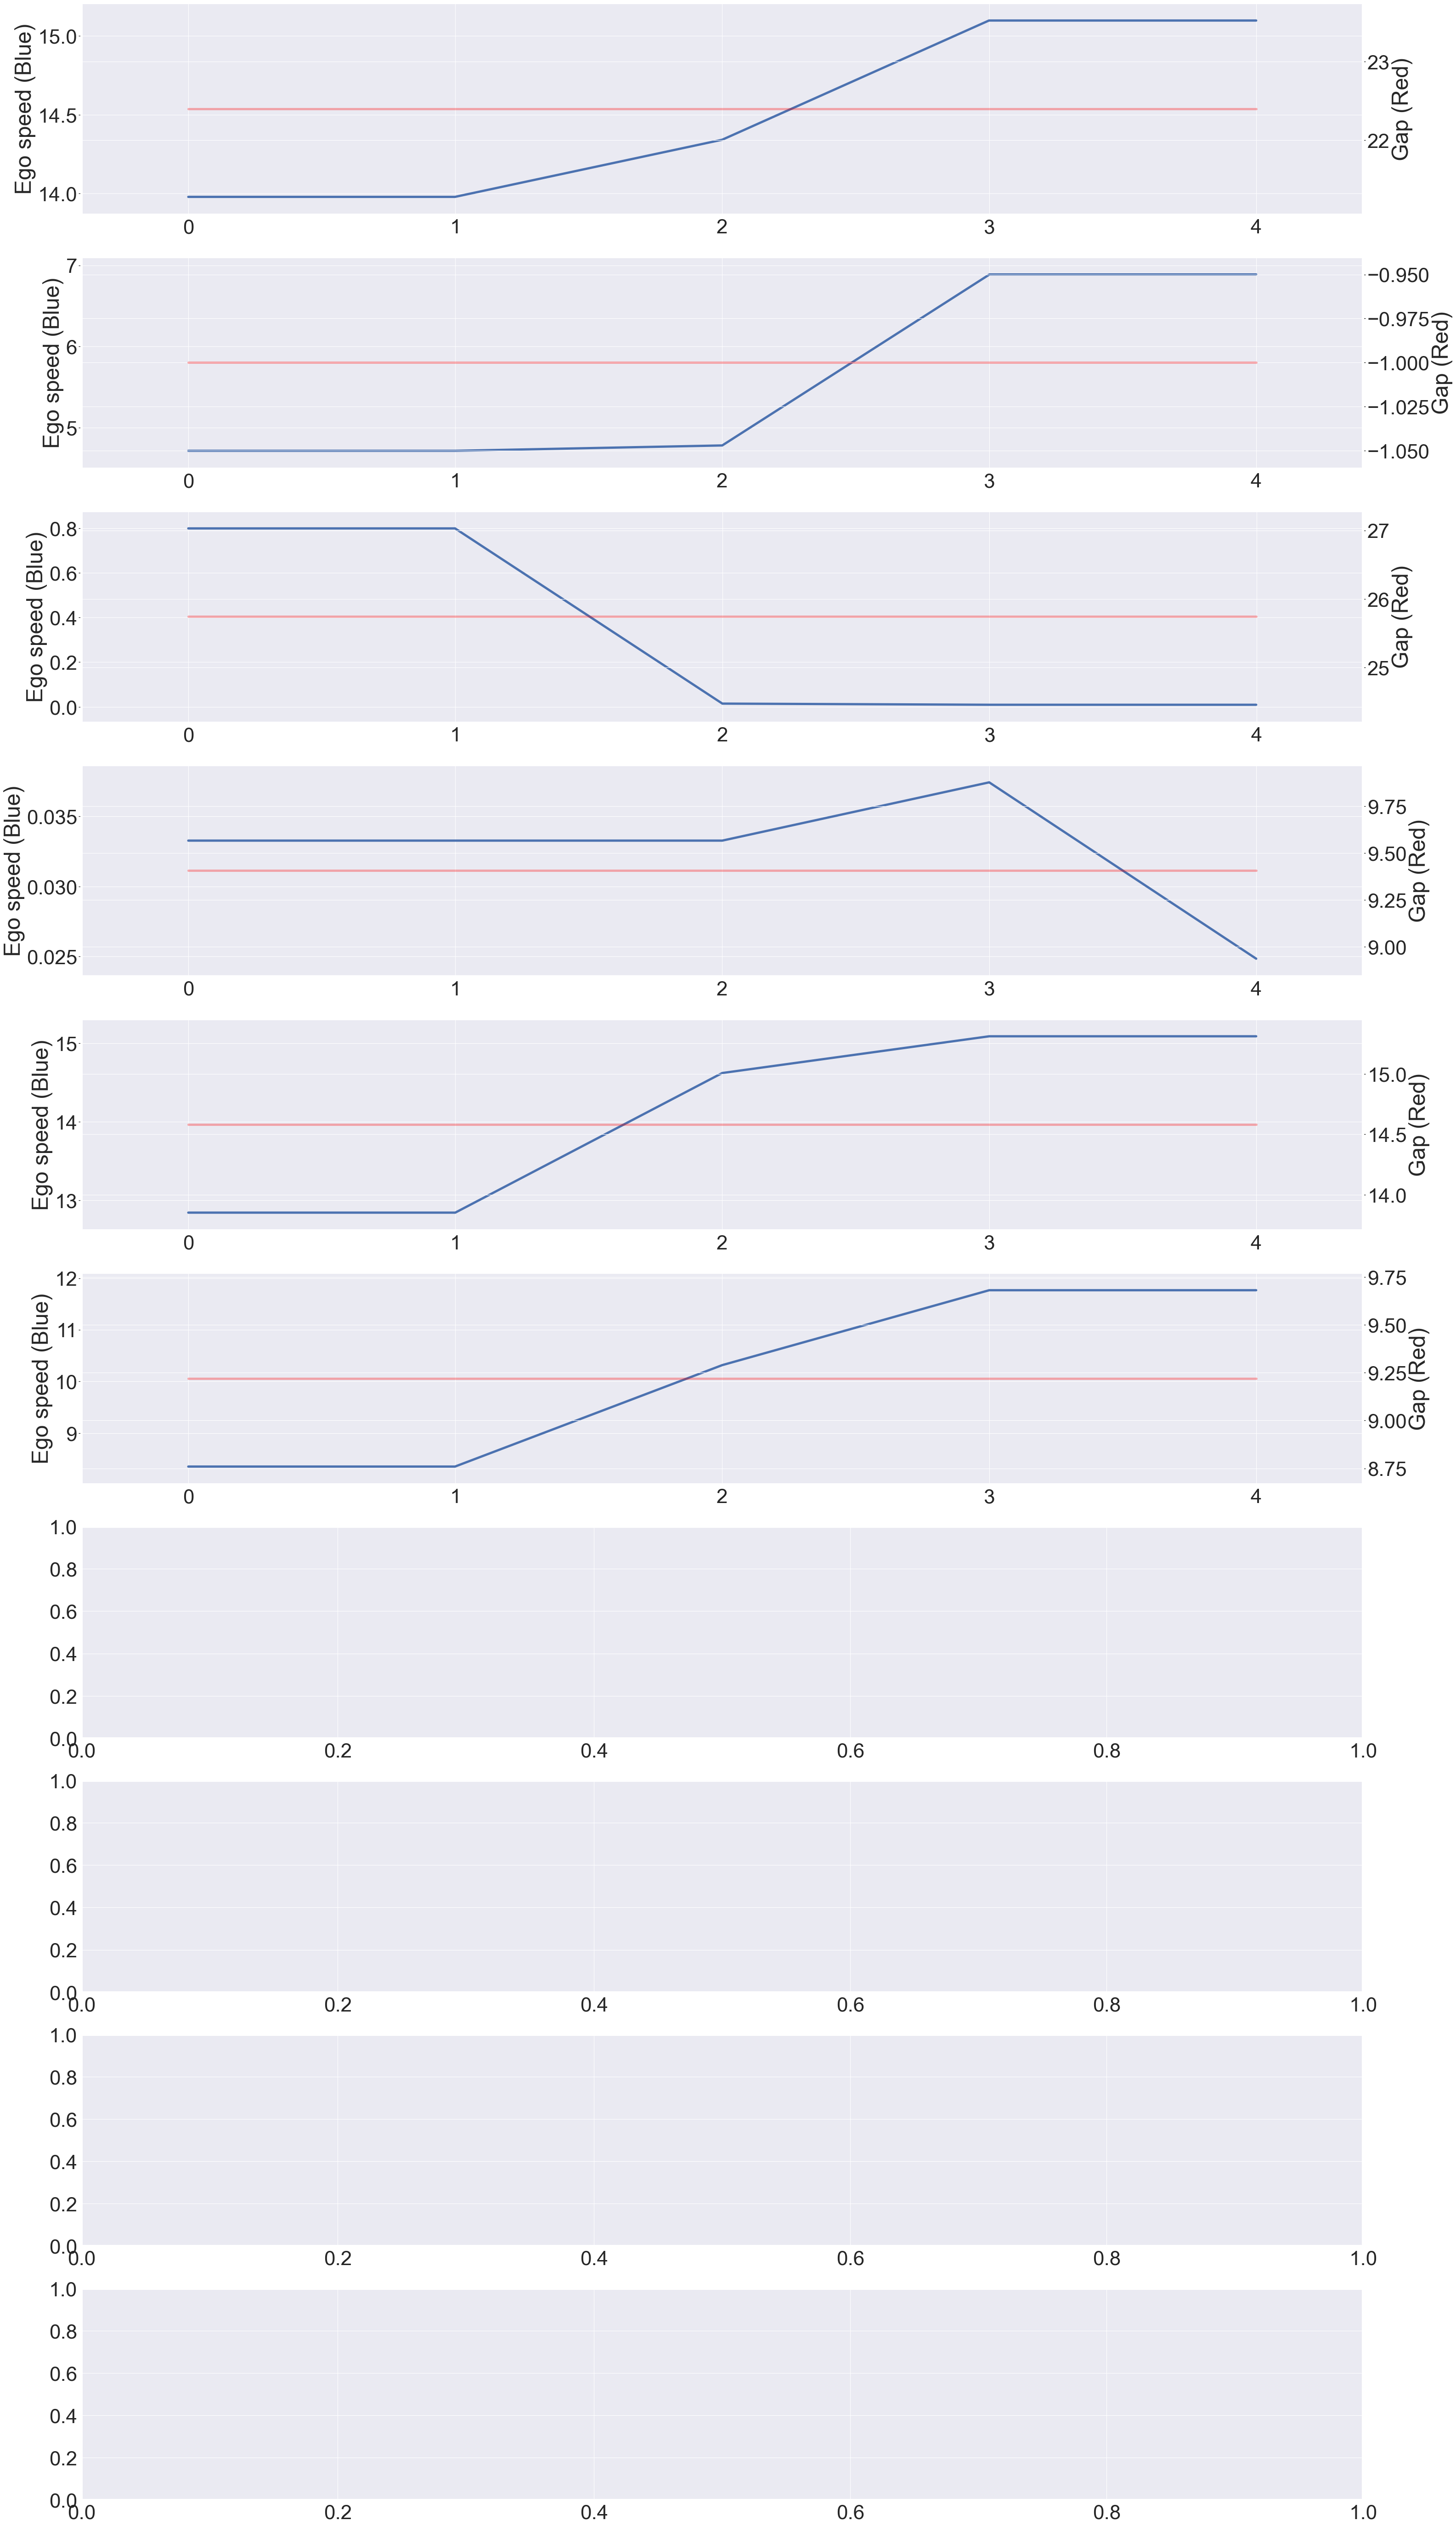

In [57]:
rows = 10
fig, ps = plt.subplots(rows, 1, figsize=(50, 10 * rows), sharex = False)
at = 0

flat_data = []
image_file_paths = []

for seq_name in all_sequence_bases[:]:
    
    a = load_json(seq_name)

    pos, speed, gap, times, orig_times = [], [], [], [], []
    init_time = None
    i = 0
    for frame in range(0, len(a['frames']) - 1): # len(a['frames']) - 1
        ego_pos = a['frames'][frame]['pose'][-3:]
        print(ego_pos)
        i+=1
        if i > 10: break
        ego_speed = 3.6 * (dist(ego_pos, a['frames'][frame + 1]['pose'][-3:]) / 1) # Freq = 2Hz but pose logged at 1Hz
        if 'annos' not in a['frames'][frame]: continue
            
        if init_time is None: init_time = int(a['frames'][frame]['frame_id'])
        
        in_front = []
        for obj_num in range(len(a['frames'][frame]['annos']['boxes_3d'])):
            if a['frames'][frame]['annos']['names'][obj_num] in set([ 'Pedestrian', 'Cyclist' ]): continue
            # This means the following object is not visible from the front cameras -- definitely not the leader
            if np.sum(a['frames'][frame]['annos']['boxes_2d']['cam03'][obj_num]) == -4: continue
            if np.sum(a['frames'][frame]['annos']['boxes_2d']['cam01'][obj_num]) == -4: continue

            obj_pos = a['frames'][frame]['annos']['boxes_3d'][obj_num][:3]
            gap_in_front = -obj_pos[1]
            gap_perpendicular = np.abs(obj_pos[0])
            
            if gap_in_front < 0.05: continue
            if gap_perpendicular > 2.5: continue
            # TODO: need a constraint for angle i.e. the object is moving in front
                
            in_front.append([ gap_perpendicular, get_speed(obj_pos) ])
        if len(in_front) > 0: gap.append(sorted(in_front)[0][1])
        else: gap.append(-1.0)

        pos.append(ego_pos)
        speed.append(ego_speed)
        times.append((int(a['frames'][frame]['frame_id']) - init_time) / 1000.0)
        orig_times.append(a['frames'][frame]['frame_id'])
        
    if len(speed) == 0: continue
        
    p = ps[at] ; at += 1
    
    smooth_speed = scipy.ndimage.median_filter(np.array(speed), size = 5)
    p.plot(times, smooth_speed)
    if at == rows: p.set_xlabel("Time (s)")
    p.set_ylabel("Ego speed (Blue)")
    ax = p.twinx()
    
    smooth_gap = scipy.ndimage.median_filter(np.array(gap), size = 30)
    ax.plot(times, smooth_gap, color = 'red', alpha = 0.3)
    ax.set_ylabel("Gap (Red)")
    
    assert len(pos) == len(times)
    assert len(pos) == len(smooth_gap)
    assert len(pos) == len(smooth_speed)
    assert len(pos) == len(orig_times)
    
    for i in range(len(pos)):
        flat_data.append([
            at - 1, 
            times[i],
            smooth_gap[i],
            smooth_speed[i],
            a['meta_info']['weather'],
            len(image_file_paths),
        ])
        
        image_file_paths.append("/".join(seq_name.split("/")[:-1]) + "/cam03/{}.jpg".format(orig_times[i]))

plt.show()
fig.savefig("all.png")
    
#     time.sleep(2)
#     break

In [27]:
image_file_paths[0]
with open("/home/noveens/common_folder/driving_data/once/metadata.npz", 'wb') as f: 
    np.savez_compressed(f, data = flat_data, image_paths = image_file_paths)

FileNotFoundError: [Errno 2] No such file or directory: '/home/noveens/common_folder/driving_data/once/metadata.npz'

In [29]:
images = []

def downsample(img):
    return img[::2, ::2, :][::2, ::2, :][::2, ::2, :] # 8x downsample

for f in tqdm(image_file_paths):
    images.append(downsample(np.asarray(Image.open(f))))

  0%|          | 0/4959 [00:00<?, ?it/s]

In [30]:
""" Stores an array of images to HDF5.
    Parameters:
    ---------------
    images       images array, (N, 32, 32, 3) to be stored
    labels       labels array, (N, 1) to be stored
"""
num_images = len(images)

# Create a new HDF5 file
file = h5py.File("./images.h5", "w")

# Create a dataset in the file
dataset = file.create_dataset(
    "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
)
file.close()

In [31]:
np.asarray(Image.open(image_file_paths[0]))[::2, ::2, :][::2, ::2, :][::2, ::2, :].shape

(128, 240, 3)

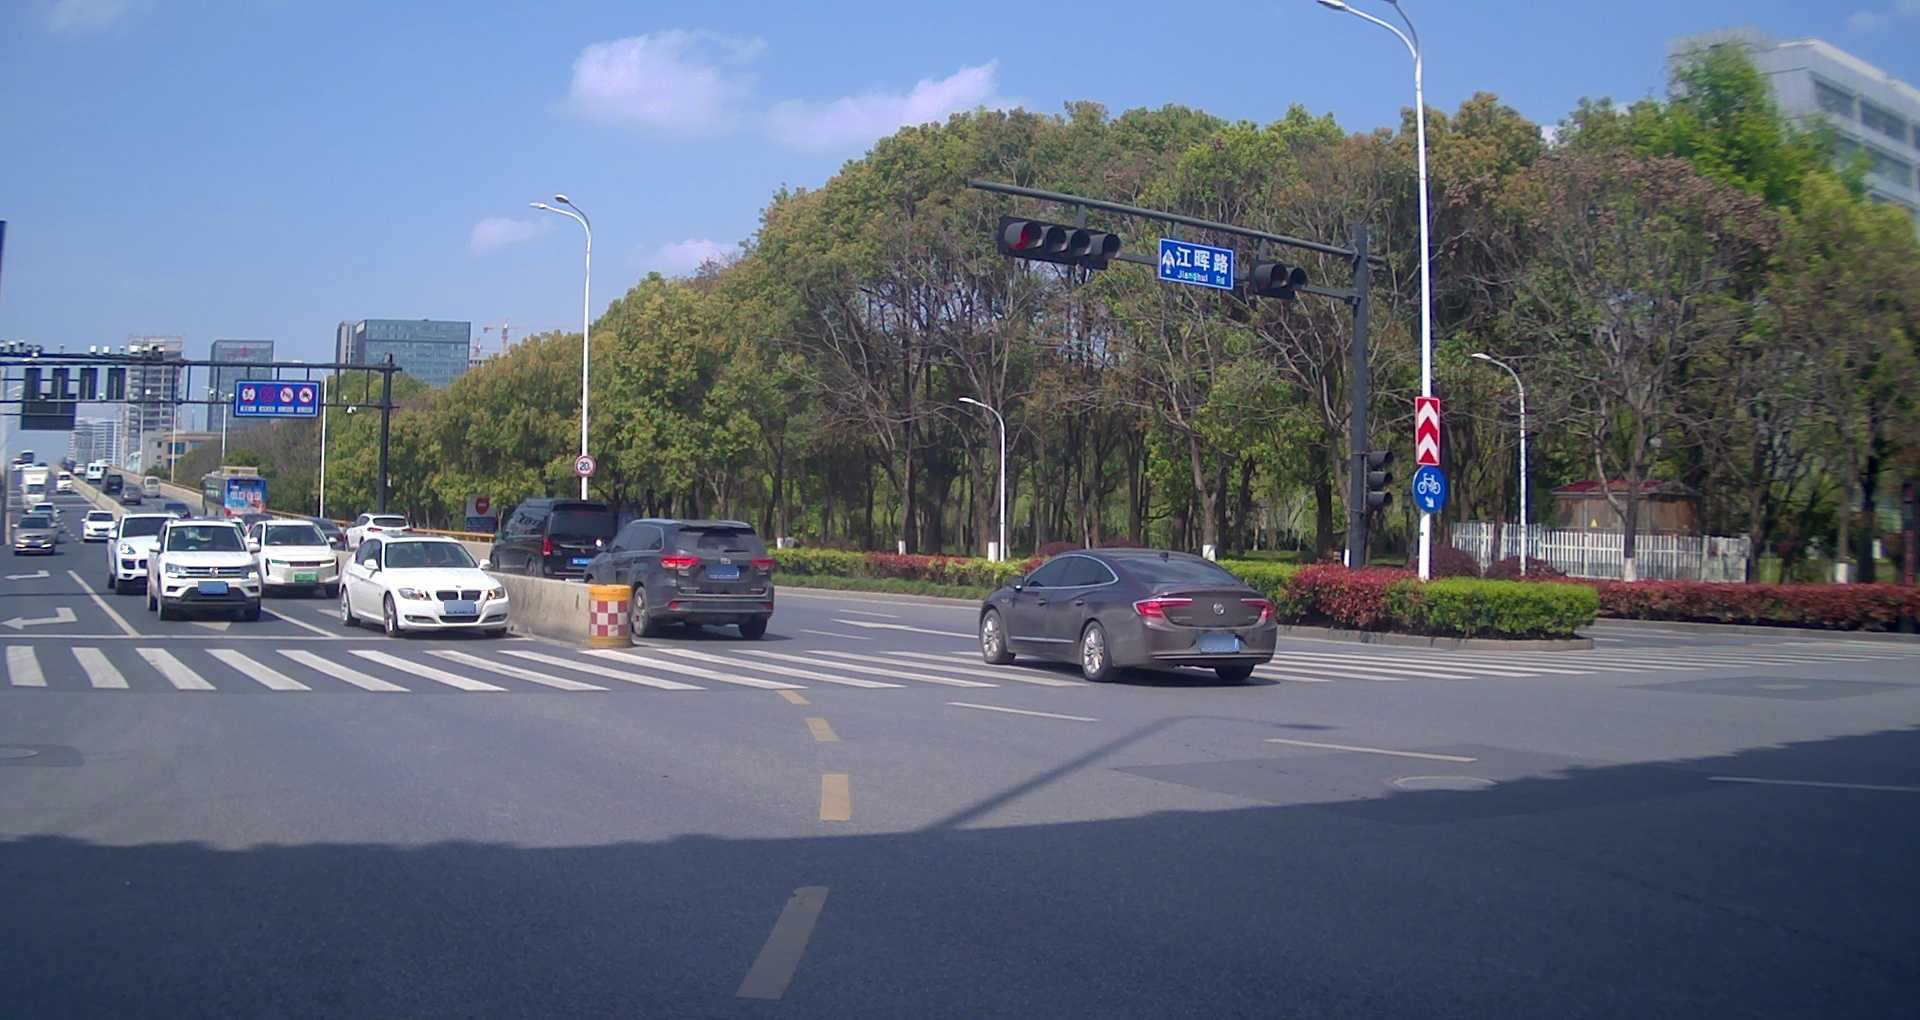

'/home/noveens/common_folder/driving_data/once/data//000113/cam03/1616535966200.jpg'

In [89]:
base = all_sequence_bases[0]
a = load_json(base)
timestamp = a['frames'][0]['frame_id']
img = "/".join(base.split("/")[:-1]) + "/cam03/{}.jpg".format(timestamp)
display(Image.open(img))
img

  0%|          | 0/150 [00:00<?, ?it/s]

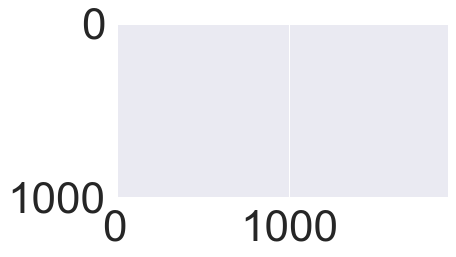

In [34]:
for seq_name in [ all_sequence_bases[5] ]:
    
    a = load_json(seq_name)
    
    fig, ax = plt.subplots() # creating my fig
    camera = Camera(fig)# the camera gets the fig we'll plot
    
    for frame in tqdm(range(0, 300, 2)): # len(a['frames']) - 1
        timestamp = a['frames'][frame]['frame_id']
        img = "/".join(seq_name.split("/")[:-1]) + "/cam03/{}.jpg".format(timestamp)
        img = Image.open(img)
        ax.imshow(img)
        camera.snap() # the camera takes a snapshot of the plot
    animation = camera.animate() # animation ready
    animation.save('animation.gif', fps=10)
    HTML(animation.to_html5_video()) # displaying the animation